# Basic CNN using tensorflow
DIY CNN using tensorflow to test capabilities on MNIST. First we need to load the dataset

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tnrange, tqdm_notebook

DATA_DIR = 'MNIST_data/'
TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
TEST_LABELS = 't10k-labels-idx1-ubyte.gz'

def _read32(bytestream):
    dt = np.dtype(np.uint32).newbyteorder('>')
    return np.frombuffer(bytestream.read(4), dtype=dt)

def load_images(filename):
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError("Invalide magic number in file")
        num_images = _read32(bytestream)[0]
        rows = _read32(bytestream)[0]
        cols = _read32(bytestream)[0]
        buf = bytestream.read(rows * cols * num_images)
        data = np.frombuffer(buf, dtype=np.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        return data
    
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = numpy.arange(num_labels) * num_classes
    labels_one_hot = numpy.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def load_labels(filename, one_hot=False):
    """Extract the labels into a 1D uint8 numpy array [index]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError(
              'Invalid magic number %d in MNIST label file: %s' %
              (magic, filename))
        num_items = _read32(bytestream)[0]
        buf = bytestream.read(num_items)
        labels = np.frombuffer(buf, dtype=np.uint8)
        if one_hot:
            return dense_to_one_hot(labels)
        return labels
    
train_images = load_images(DATA_DIR + TRAIN_IMAGES)[:12000]
train_labels = load_labels(DATA_DIR + TRAIN_LABELS)[:12000]
test_images = load_images(DATA_DIR + TEST_IMAGES)[:2000]
test_labels = load_labels(DATA_DIR + TEST_LABELS)[:2000]
print("Train-images:", train_images.shape)
print("Train-labels:", train_labels.shape)
print("Test:", test_images.shape)
print("Test-labels:", test_labels.shape)

'''
train_images_flat = []
for image in train_images[:,:,:,0]:
    train_images_flat.append(image.flatten())
train_images_flat = np.array(train_images_flat)
print(train_images_flat.shape)

test_images_flat = []
for image in test_images[:,:,:,0]:
    test_images_flat.append(image.flatten())
test_images_flat = np.array(test_images_flat)
print(test_images_flat.shape)
'''

Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Train-images: (12000, 28, 28, 1)
Train-labels: (12000,)
Test: (2000, 28, 28, 1)
Test-labels: (2000,)


'\ntrain_images_flat = []\nfor image in train_images[:,:,:,0]:\n    train_images_flat.append(image.flatten())\ntrain_images_flat = np.array(train_images_flat)\nprint(train_images_flat.shape)\n\ntest_images_flat = []\nfor image in test_images[:,:,:,0]:\n    test_images_flat.append(image.flatten())\ntest_images_flat = np.array(test_images_flat)\nprint(test_images_flat.shape)\n'

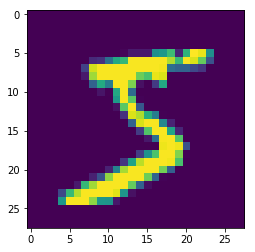

Label: 5


In [2]:
# Print the first image as test
plt.imshow(train_images[0,:,:,0])
plt.show()
print("Label:", train_labels[0])

## NN dense with TF
We are going to implement a simple dense NN using tensorflow (not CNN). This won't be very accurate I think. The number of inputs is 784 (28^2). We will use a single hidden layer of variable size. The output is a 10-class softmax representing the estimated digit. We need first to define a layer, then the network

In [3]:
class Layer:
    
    # Bias will turn on/off bias at the activation side, zeros will set all weights to zero initially
    def __init__(self, input_size, output_size, f, bias=True, zeros=False):
        if zeros:
            self.W = np.zeros((input_size, output_size), dtype=np.float32)
        else:
            self.W = tf.random_normal(shape=(input_size, output_size))
        self.W = tf.Variable(self.W)
        
        self.bias = bias
        if bias:
            self.b = tf.Variable(np.zeros(output_size).astype(np.float32))
        
        self.f = f
        
    def forward(self, X):
        if self.bias:
            a = tf.matmul(X, self.W) + self.b
        else:
            a = tf.matmul(X, self.W)
        return self.f(a)

In [4]:
class Model:
    
    def __init__(self, input_size, output_size, hidden_layer_sizes = []):
        self.layers = []
        # Add hidden layers
        prev_dim = input_size
        for layer_size in hidden_layer_sizes:
            layer = Layer(prev_dim, layer_size, tf.nn.tanh)
            self.layers.append(layer)
            prev_dim = layer_size
        # Define placeholder
        self.X = tf.placeholder(tf.float32, shape=(None, input_size), name='X')
        self.Y = tf.placeholder(tf.int64, shape=(None, ), name='Y')
        # Compute output
        Z = self.X
        for layer in self.layers:
            Z = layer.forward(Z)
        self.Y_hat = tf.contrib.layers.softmax(logits=Z)
        self.predict_op = tf.argmax(self.Y_hat, axis=-1)
        # Train
        self.Y_oh = tf.one_hot(indices=tf.cast(self.Y, tf.int32), depth=10)
        self.loss = tf.losses.sigmoid_cross_entropy(self.Y_oh, logits=Z)
        self.train_op = tf.train.GradientDescentOptimizer(1e-1).minimize(self.loss)
        self.correct = tf.equal(self.predict_op, self.Y)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct, tf.float32))
    
    def set_session(self, session):
        self.session = session
        
    def train(self, X, Y):
        X = np.atleast_2d(X)
        Y = np.atleast_1d(Y)
        return self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})
    
    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.predict_op, feed_dict={self.X : X})
    
    def get_accuracy(self, X, Y):
        return self.session.run(self.accuracy, feed_dict={self.X: X, self.Y: Y})

In [5]:
# Tests
'''
nn = Model(784, 10, [100, 10])
session = tf.InteractiveSession()
init = tf.global_variables_initializer()
session.run(init)
nn.set_session(session)

print(nn.get_accuracy(test_images_flat, test_labels))
for i in tqdm_notebook(range(1000), desc='Epochs'):
    nn.train(train_images_flat, train_labels)
print(nn.get_accuracy(test_images_flat, test_labels))
'''

"\nnn = Model(784, 10, [100, 10])\nsession = tf.InteractiveSession()\ninit = tf.global_variables_initializer()\nsession.run(init)\nnn.set_session(session)\n\nprint(nn.get_accuracy(test_images_flat, test_labels))\nfor i in tqdm_notebook(range(1000), desc='Epochs'):\n    nn.train(train_images_flat, train_labels)\nprint(nn.get_accuracy(test_images_flat, test_labels))\n"

Now I will implement a CNN with 1 conv layer, 1 pool layer, 1 dense layer

In [6]:
class CNN:
    
    def __init__(self, train_size, batch_size=100, use_tqdm=False):
        self.X = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
        self.Y = tf.placeholder(tf.int64, shape=(None))
        self.is_training= tf.placeholder(tf.bool, shape=(None))
        # Convolution
        self.c1 = tf.contrib.layers.conv2d(inputs=self.X, num_outputs=32, kernel_size=8)
        self.c2 = tf.contrib.layers.conv2d(inputs=self.c1, num_outputs=64, kernel_size=3)
        self.p2 = tf.contrib.layers.max_pool2d(inputs=self.c2, kernel_size=2)
        self.p2d = tf.contrib.layers.dropout(inputs=self.p2, keep_prob=0.25, is_training=self.is_training[0])
        # Flattening
        self.flatted = tf.contrib.layers.flatten(inputs=self.p2d)
        # Dense
        self.d1 = tf.contrib.layers.fully_connected(inputs=self.flatted, num_outputs=128)
        self.dropped = tf.contrib.layers.dropout(inputs=self.d1, keep_prob=0.5, is_training=self.is_training[0])
        self.d2 = tf.contrib.layers.fully_connected(inputs=self.dropped, num_outputs=10, activation_fn=None)
        # Predictions and softmax
        self.prediction = tf.argmax(self.d2, axis=1)
        self.probabilities = tf.contrib.layers.softmax(logits=self.d2)
        # One hot
        self.Y_oh = tf.one_hot(indices=tf.cast(self.Y, tf.int32), depth=10)
        self.loss = tf.losses.softmax_cross_entropy(self.Y_oh, logits=self.d2)
        # Optimization
        self.batch_size = batch_size
        self.use_tqdm = use_tqdm
        batch = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(
            1e-3,  # Base learning rate.
            batch * self.batch_size,  # Current index into the dataset.
            train_size,  # Decay step.
            0.95,  # Decay rate.
            staircase=True)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss, global_step=batch)
        # Accuracy
        self.correct = tf.equal(self.prediction, self.Y)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct, tf.float32))
        
    def set_session(self, session):
        self.session = session
        
    def predict(self, X):
        return self.session.run(self.prediction, feed_dict={self.X: X, self.is_training: [False]})
    
    def train(self, X, Y):
        if self.use_tqdm:
            a = tqdm_notebook(range(0, len(X), self.batch_size), desc='Batches')
        else:
            a = range(0, len(X), self.batch_size)
        for batch_pivot in a:
            self.session.run(self.train_op, feed_dict={self.X: X[batch_pivot:batch_pivot+self.batch_size], self.Y: Y[batch_pivot:batch_pivot+self.batch_size], self.is_training: [True]})
    
    def get_accuracy(self, X, Y):
        return self.session.run(self.accuracy, feed_dict={self.X: X, self.Y: Y, self.is_training: [False]})
    

In [7]:
cnn_model = CNN(train_images.shape[0], batch_size=50, use_tqdm=True)
session = tf.InteractiveSession()
init = tf.global_variables_initializer()
session.run(init)
cnn_model.set_session(session)

print(cnn_model.get_accuracy(train_images, train_labels))
for i in tqdm_notebook(range(10), desc='Epochs'):
    cnn_model.train(train_images, train_labels)
print("TRAIN ACCURACY:", cnn_model.get_accuracy(train_images, train_labels))
print("TEST ACCURACY:", cnn_model.get_accuracy(test_images, test_labels))

0.0676667

TRAIN ACCURACY: 0.992833
TEST ACCURACY: 0.966
